<a href="https://colab.research.google.com/github/hellocybernetics/Tensorflow-Probability-Tutorials/blob/master/tutorials/03_advanced/Gaussian_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 前準備

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

print(tf.__version__)
print(tfp.__version__)

1.12.0
0.5.0


In [0]:
# tfe = tf.contrib.eager
tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

In [0]:
# tf.enable_eager_execution()

### ガウシアンプロセス回帰の実験

In [0]:
observation_noise_variance = 0.2

def f(x):
    return (np.sin(10*x[..., 0]) + np.cos(5*x[..., 0])) * np.exp(-x[..., 0]**2)

observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = (f(observation_index_points) +
                np.random.normal(0., np.sqrt(observation_noise_variance),
                                size=(50,)))

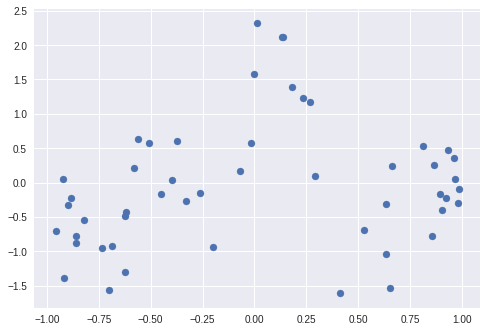

In [0]:
plt.scatter(observation_index_points, observations)

In [0]:
index_points = np.linspace(-1., 1., 200)[..., np.newaxis]

In [0]:
kernel = psd_kernels.MaternFiveHalves()

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

In [0]:
sample_gprm = gprm.sample(10)

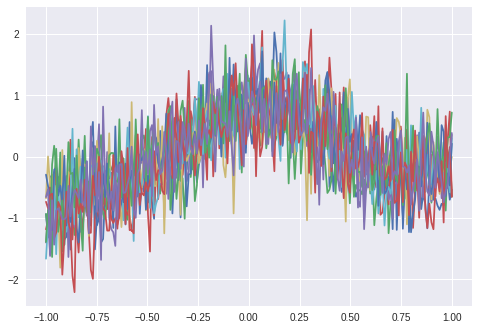

In [0]:
with tf.Session() as sess:
    sample_gprm_ = sess.run(sample_gprm)
    for i in range(10):
        plt.plot(index_points, sample_gprm_[i])

### ガウシアンプロセスのトレーニング

In [0]:
# f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)

observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = f(observation_index_points) + np.random.normal(0., .2, 50)

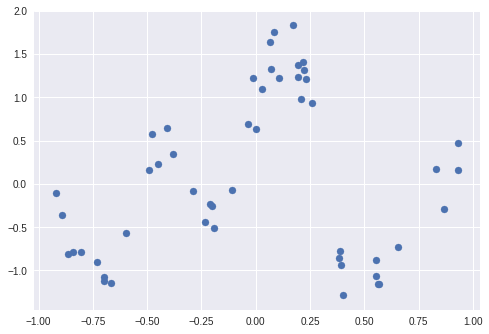

In [0]:
plt.scatter(observation_index_points, observations)

In [0]:
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(0)), name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

In [0]:
observation_noise_variance = tf.exp(
    tf.Variable(np.float64(0)), name='observation_noise_variance')

In [0]:
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)
neg_log_likelihood = -gp.log_prob(observations)

optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
optimize = optimizer.minimize(neg_log_likelihood)

In [0]:
index_points = np.linspace(-1.5, 1.5, 200)[..., np.newaxis]
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10)

Final NLL = 13.857868434609948


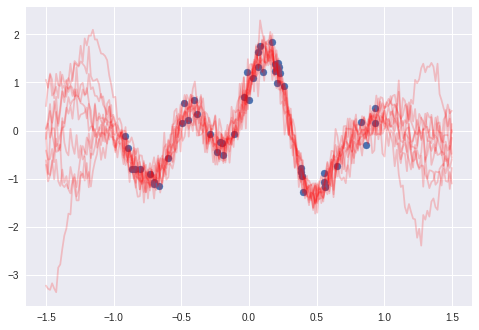

In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        _, neg_log_likelihood_ = sess.run([optimize, neg_log_likelihood])
    if i % 100 == 0:
        print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

    print("Final NLL = {}".format(neg_log_likelihood_))
    samples_ = sess.run(samples)

    plt.scatter(np.squeeze(observation_index_points), observations)
    plt.plot(np.stack([index_points[:, 0]]*10).T, samples_.T, c='r', alpha=.2)

### MCMCを用いた事後分布推論

In [0]:
observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = np.random.normal(f(observation_index_points), .2)

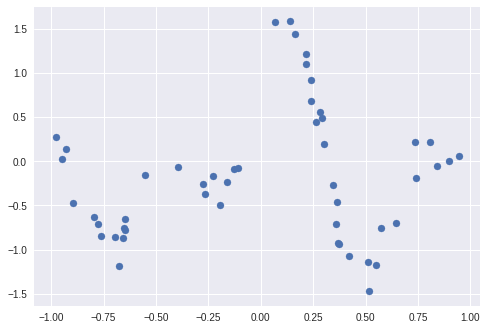

In [0]:
plt.scatter(observation_index_points, observations)

In [0]:
def joint_log_prob(
    index_points, observations, amplitude, length_scale, noise_variance):

    # Hyperparameter Distributions.
    rv_amplitude = tfd.LogNormal(np.float64(0.), np.float64(1))
    rv_length_scale = tfd.LogNormal(np.float64(0.), np.float64(1))
    rv_noise_variance = tfd.LogNormal(np.float64(0.), np.float64(1))

    gp = tfd.GaussianProcess(
      kernel=psd_kernels.ExponentiatedQuadratic(amplitude, length_scale),
      index_points=index_points,
      observation_noise_variance=noise_variance)

    return (
      rv_amplitude.log_prob(amplitude) +
      rv_length_scale.log_prob(length_scale) +
      rv_noise_variance.log_prob(noise_variance) +
      gp.log_prob(observations)
    )


In [0]:
initial_chain_states = [
    1e-1 * tf.ones([], dtype=np.float64, name='init_amplitude'),
    1e-1 * tf.ones([], dtype=np.float64, name='init_length_scale'),
    1e-1 * tf.ones([], dtype=np.float64, name='init_obs_noise_variance')
]

In [0]:
unconstraining_bijectors = [
    tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus(),
]

In [0]:
def unnormalized_log_posterior(amplitude, length_scale, noise_variance):
    return joint_log_prob(
      observation_index_points, observations, amplitude, length_scale,
      noise_variance)

In [0]:
num_results = 20
[
    amplitudes,
    length_scales,
    observation_noise_variances
], kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=500,
    num_steps_between_results=5,
    current_state=initial_chain_states,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            step_size=[np.float64(.25)],
            num_leapfrog_steps=3),
        bijector=unconstraining_bijectors))


In [0]:
gprm = tfd.GaussianProcessRegressionModel(
    # Batch of `num_results` kernels parameterized by the MCMC samples.
    kernel=psd_kernels.ExponentiatedQuadratic(amplitudes, length_scales),
    index_points=np.linspace(-2., 2., 200)[..., np.newaxis],
    observation_index_points=observation_index_points,
    observations=observations,
    # We reshape this to align batch dimensions.
    observation_noise_variance=observation_noise_variances[..., np.newaxis])
samples = gprm.sample()


Acceptance rate: 0.05


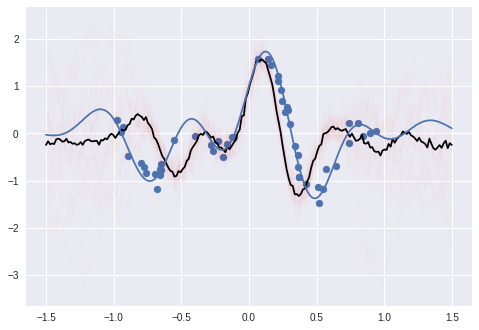

In [0]:
with tf.Session() as sess:
    kernel_results_, samples_ = sess.run([kernel_results, samples])

    print("Acceptance rate: {}".format(
      np.mean(kernel_results_.inner_results.is_accepted)))

    # Plot posterior samples and their mean, target function, and observations.
    plt.plot(np.stack([index_points[:, 0]]*num_results).T,
           samples_.T,
           c='r',
           alpha=.01)
    plt.plot(index_points[:, 0], np.mean(samples_, axis=0), c='k')
    plt.plot(index_points[:, 0], f(index_points))
    plt.scatter(observation_index_points[:, 0], observations)
